# PROJECT: CUSTOMER SEGMENTATION FOR A MARKETING CAMPAIGN 

# 1. Prerequisites 

In [4]:
import time
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score 
from sklearn.decomposition import PCA 

# 2. Implementation of Functions

In [5]:
RANDOM_SEED = 1

In [6]:
def calculate_metrics(data, max_clusters):

    inertias = []  
    silhouette_scores = []  
    db_scores = []  
    ch_scores = []  
    fit_times = []  

    for k in range(2, max_clusters + 1):
        start_time = time.time()  

        kmeans = KMeans(n_clusters=k, n_init=10, init="k-means++")
        kmeans.fit(data)
        labels = kmeans.labels_

        inertia = kmeans.inertia_
        sil_score = silhouette_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        ch_score = calinski_harabasz_score(data, labels)

        end_time = time.time()  
        fit_time = end_time - start_time  

        inertias.append(inertia)
        silhouette_scores.append(sil_score)
        db_scores.append(db_score)
        ch_scores.append(ch_score)
        fit_times.append(fit_time)


    best_K = np.argmax([np.mean(silhouette_scores), -np.mean(db_scores), np.mean(ch_scores)])
    best_K += 2  
    best_inertia = inertias[best_K - 2]
    best_silhouette = silhouette_scores[best_K - 2]
    best_db = db_scores[best_K - 2]
    best_ch = ch_scores[best_K - 2]

    return inertias, silhouette_scores, db_scores, ch_scores, fit_times, best_K, best_inertia, best_silhouette, best_db, best_ch

In [90]:
def plot_metrics(inertias, silhouette_scores, db_scores, ch_scores, fit_times, best_K, best_inertia, best_silhouette, best_db, best_ch):

    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()

    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax4.set_ylabel('')
    ax3.set_ylabel('')

    ax1.tick_params(axis='y', which='both', labelcolor='w', left=False, right=False, labelleft=False, labelright=False)
    ax2.tick_params(axis='y', which='both', labelcolor='w', left=False, right=False, labelleft=False, labelright=False)
    ax3.tick_params(axis='y', which='both', labelcolor='w', left=False, right=False, labelleft=False, labelright=False)
    ax4.tick_params(axis='y', which='both', labelcolor='w', left=False, right=False, labelleft=False, labelright=False)

    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    ax4.grid(False)

    ax1.grid(True, axis="x")

    ax1.plot(range(2, len(inertias) + 2), inertias, 'b-', label='Inertia', marker="o")
    ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, 'r-', label='Silhouette Score', marker="o")
    ax3.plot(range(2, len(db_scores) + 2), db_scores, 'c-', label='Davies-Bouldin Index', marker="o")
    ax4.plot(range(2, len(ch_scores) + 2), ch_scores, 'g-', label='Calinski Harabasz Index', marker="o")

    ax1.set_xlabel('Number of Clusters')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax3.legend(loc='lower left')
    ax4.legend(loc='lower right')

    ax1.axvline(x=best_K, color='orange', linestyle='--', label='Best K')
    ax1.text(best_K + 0.1, max(inertias), f'K = {best_K}', horizontalalignment='left', verticalalignment='top', color='orange', fontweight='bold')

    fig.tight_layout()

    plt.show()

    print()
    print(f'BEST NUMBER OF CLUSTERS (K): {best_K}\nInertia: {best_inertia:.2f}\nSilhouette Score: {best_silhouette:.2f}\nDavies-Bouldin Index: {best_db:.2f}\nCalinski Harabasz Index: {best_ch:.2f}')

In [91]:
def show_metrics(data, max_clusters):

    inertias, silhouette_scores, db_scores, ch_scores, fit_times, best_K, best_inertia, best_silhouette, best_db, best_ch = calculate_metrics(data, max_clusters)

    plot_metrics(inertias, silhouette_scores, db_scores, ch_scores, fit_times, best_K, best_inertia, best_silhouette, best_db, best_ch)

In [92]:
def plot_scatter_pca(X_pca, y_kmeans, centroids):
    
    plt.figure(figsize=(15, 10))
    
    for i in range(K):
        plt.scatter(X_pca[y_kmeans == i, 0], X_pca[y_kmeans == i, 1], label=f'Cluster {i+1}', edgecolors='black')
        
    plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=100, alpha=0.7, label='Centroids')
    
    plt.legend()
    
    plt.show()

In [93]:
def calculate_clusters_profile(df_final):
    
    df_final['CLUSTER'] = df_final['CLUSTER'].astype(str).apply(lambda x: x if x.startswith('Cluster') else 'Cluster ' + x)
    
    df_profile_overall = pd.DataFrame()
    df_profile_overall['Total'] = df_final.describe().loc[['mean']].T
    
    df_cluster_summary = df_final.groupby('CLUSTER').describe().T.reset_index().rename(columns={'level_0': 'Name Column', 'level_1': 'Metrics'})
    df_cluster_summary = df_cluster_summary[df_cluster_summary['Metrics'] == 'mean'].set_index('Name Column')
    df_cluster_summary['Metrics'] = 'Media'
    
    df_profile = df_cluster_summary.join(df_profile_overall).reset_index()
    
    display(df_profile)


In [94]:
def show_report(df):
    
    col_type = df.dtypes
    not_null_counts = df.count()
    unique_counts = df.nunique()
    unique_percent = (unique_counts / len(df)) * 100
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    min_values = df.min()
    max_values = df.max()
    zero_counts = (df == 0).sum()
    zero_percent = (zero_counts / len(df)) * 100

    mean_values = pd.Series(dtype='float64')
    median_values = pd.Series(dtype='float64')
    
    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            mean_values[column] = df[column].mean()
            median_values[column] = df[column].median()
        else:
            mean_values[column] = np.nan
            median_values[column] = np.nan
            
    report_df = pd.DataFrame({
        "Data Type": col_type,
        "Non-Zero Values": not_null_counts,
        "Missing Values": missing_counts,
        "% Missing Values": round(missing_percent, 2),
        "Unique Values": unique_counts,
        "% Unique Values": round(unique_percent, 2),
        "Zero Values": zero_counts,
        "% Zero Values": round(zero_percent, 2),
        "Min Value": min_values,
        "Max Value": max_values,
        "Media": mean_values,
        "Median": median_values
    })
    
    df_shape = df.shape

    print(f'DATAFRAME HAS {df_shape[0]} LINES AND {df_shape[1]} COLUMNS')
    print()
    
    display(report_df)        

In [95]:
def show_correlation_matrix(df):
    
    df_num = df.select_dtypes(include=np.number)

    corr_matrix = df_num.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(14, 10))

    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Greens', linewidths=0.1, cbar=False, annot_kws={"size": 9})

    yticks, ylabels = plt.yticks()
    xticks, xlabels = plt.xticks()
    ax.set_xticklabels(xlabels, size=8, fontfamily='serif')
    ax.set_yticklabels(ylabels, size=8, fontfamily='serif')

    ax.grid(False)

    plt.tight_layout(rect=[0, 0.04, 1, 1.01])

    plt.show()

In [117]:
def plot_distributions(dataframe):
    
    dataframe = dataframe.select_dtypes(include='number')

    num_cols = dataframe.shape[1]
    num_rows = (num_cols - 1) // 3 + 1  

    fig, axes = plt.subplots(num_rows, 3, figsize=(16, 10))
    fig.subplots_adjust(hspace=1, wspace=0.5)  

    for i, col in enumerate(dataframe.columns):
        row_idx = i // 3 
        col_idx = i % 3   
        ax = axes[row_idx, col_idx] 
        dataframe[col].plot(kind='hist', color='Purple', ax=ax)  
        ax.set_title(col)  
        ax.grid(False) 

    if num_rows * 3 > num_cols:
        for i in range(num_cols, num_rows * 3):
            fig.delaxes(axes.flatten()[i])

    plt.show()

In [118]:
def remove_null_value(df):

    null_columns = df.columns[df.isnull().any()].tolist()

    imputer = KNNImputer()
    df_imp = pd.DataFrame(imputer.fit_transform(df[null_columns]), columns=null_columns)

    df = df.fillna(df_imp)

    return df

# 3. Data Loading

In [119]:
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv"
df = pd.read_csv(DATASET_URL)
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


# 4. Explore the contours of the Dataset

In [120]:
show_report(df)

DATAFRAME HAS 8950 LINES AND 18 COLUMNS



,Data Type,Non-Zero Values,Missing Values,% Missing Values,Unique Values,% Unique Values,Zero Values,% Zero Values,Min Value,Max Value,Media,Median
CUST_ID,object,8950,0,0.00,8950,100.00,0,0.00,C10001,C19190,NaN,NaN
BALANCE,float64,8950,0,0.00,8871,99.12,80,0.89,0.0,19043.13856,1564.474828,873.385231
BALANCE_FREQUENCY,float64,8950,0,0.00,43,0.48,80,0.89,0.0,1.0,0.877271,1.000000
PURCHASES,float64,8950,0,0.00,6203,69.31,2044,22.84,0.0,49039.57,1003.204834,361.280000
ONEOFF_PURCHASES,float64,8950,0,0.00,4014,44.85,4302,48.07,0.0,40761.25,592.437371,38.000000
INSTALLMENTS_PURCHASES,float64,8950,0,0.00,4452,49.74,3916,43.75,0.0,22500.0,411.067645,89.000000
CASH_ADVANCE,float64,8950,0,0.00,4323,48.30,4628,51.71,0.0,47137.21176,978.871112,0.000000
PURCHASES_FREQUENCY,float64,8950,0,0.00,47,0.53,2043,22.83,0.0,1.0,0.490351,0.500000
ONEOFF_PURCHASES_FREQUENCY,float64,8950,0,0.00,47,0.53,4302,48.07,0.0,1.0,0.202458,0.083333
PURCHASES_INSTALLMENTS_FREQUENCY,float64,8950,0,0.00,47,0.53,3915,43.74,0.0,1.0,0.364437,0.166667


# 5. Data Preparation and Visualization

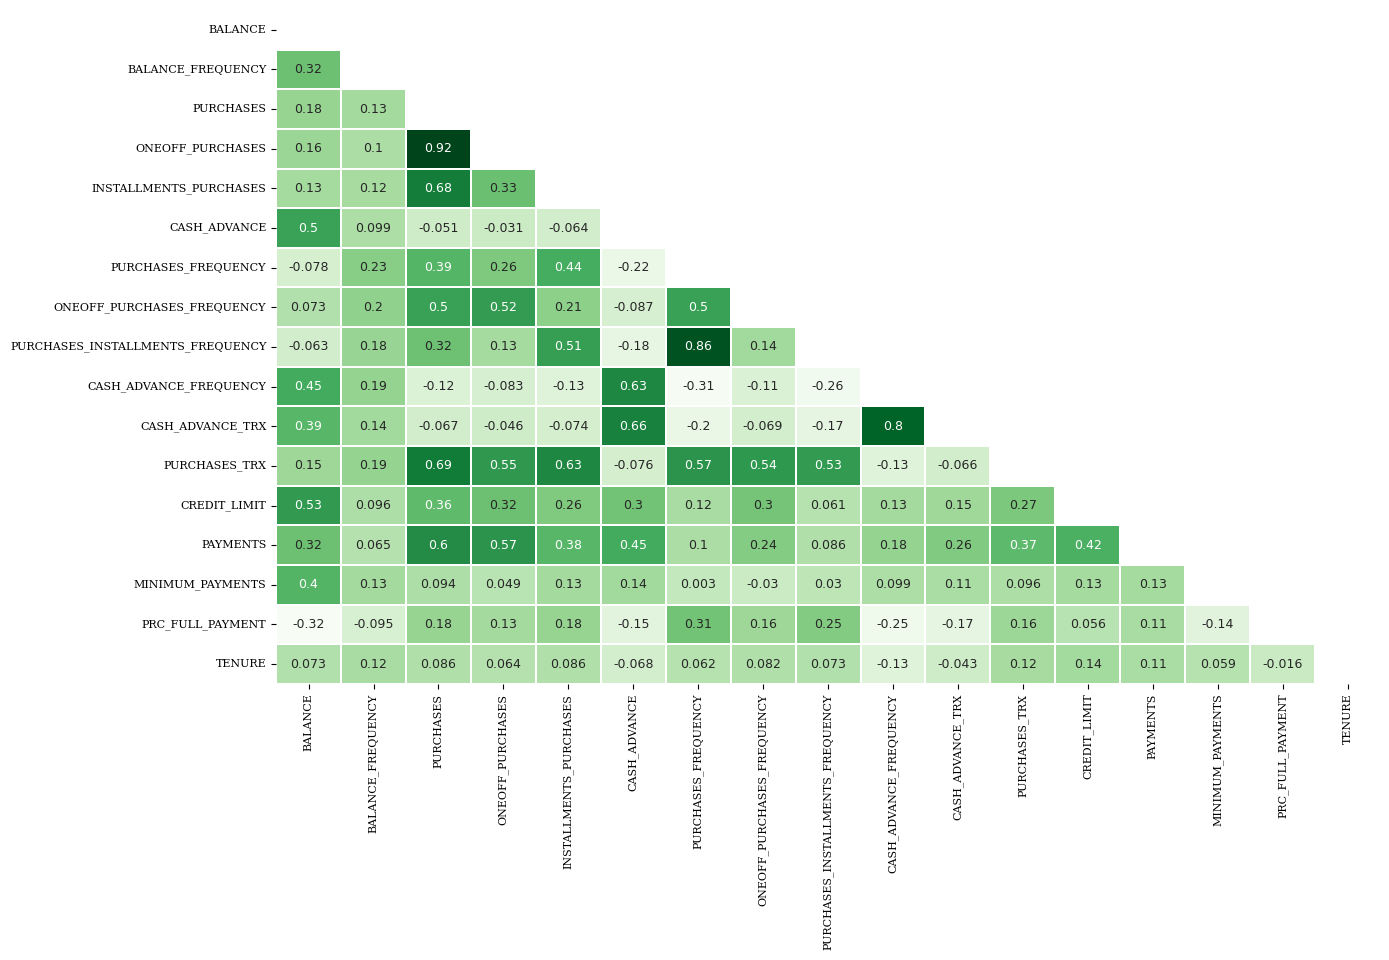

In [121]:
show_correlation_matrix(df)

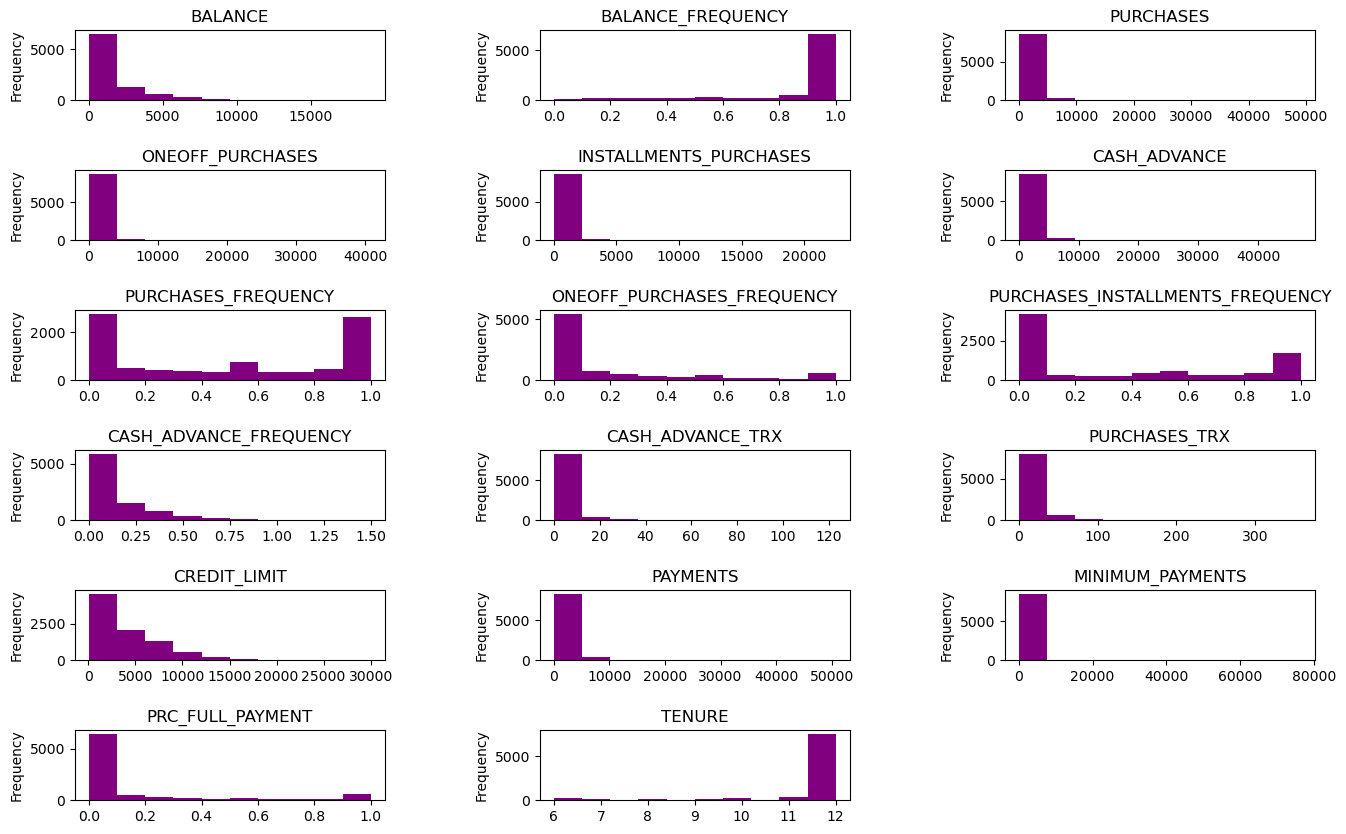

In [122]:
plot_distributions(df)

By carrying out a preliminary analysis of the data, we can see that the CUST_ID column should be eliminated from our model. There are several missing values in MINIMUM_PAYMENTS and we can see a fair correlation between ONEOFF_PURCHASES and PURCHASES and PURCHASES_INSTALLMENTS_FREQUENCY and PURCHASES_FREQUENCY.

# 6. Handling missing Values

In [102]:
df_clean = remove_null_value(df)
df_clean.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,1215.951453,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [103]:
show_report(df_clean)

DATAFRAME HAS 8950 LINES AND 18 COLUMNS



,Data Type,Non-Zero Values,Missing Values,% Missing Values,Unique Values,% Unique Values,Zero Values,% Zero Values,Min Value,Max Value,Media,Median
CUST_ID,object,8950,0,0.0,8950,100.00,0,0.00,C10001,C19190,NaN,NaN
BALANCE,float64,8950,0,0.0,8871,99.12,80,0.89,0.0,19043.13856,1564.474828,873.385231
BALANCE_FREQUENCY,float64,8950,0,0.0,43,0.48,80,0.89,0.0,1.0,0.877271,1.000000
PURCHASES,float64,8950,0,0.0,6203,69.31,2044,22.84,0.0,49039.57,1003.204834,361.280000
ONEOFF_PURCHASES,float64,8950,0,0.0,4014,44.85,4302,48.07,0.0,40761.25,592.437371,38.000000
INSTALLMENTS_PURCHASES,float64,8950,0,0.0,4452,49.74,3916,43.75,0.0,22500.0,411.067645,89.000000
CASH_ADVANCE,float64,8950,0,0.0,4323,48.30,4628,51.71,0.0,47137.21176,978.871112,0.000000
PURCHASES_FREQUENCY,float64,8950,0,0.0,47,0.53,2043,22.83,0.0,1.0,0.490351,0.500000
ONEOFF_PURCHASES_FREQUENCY,float64,8950,0,0.0,47,0.53,4302,48.07,0.0,1.0,0.202458,0.083333
PURCHASES_INSTALLMENTS_FREQUENCY,float64,8950,0,0.0,47,0.53,3915,43.74,0.0,1.0,0.364437,0.166667


In [104]:
df_features = df_clean.drop(['CUST_ID'], axis=1)
df_features.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,1215.951453,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [105]:
df_norm = pd.DataFrame(StandardScaler().fit_transform(df_features))
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960383,-0.528979,-0.311729,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688676,0.818642,0.087047,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826098,-0.383805,-0.103210,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826098,-0.598688,0.148440,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905414,-0.364368,-0.266722,-0.525551,0.36068


In [106]:
X = np.asarray(df_norm)

# 7. PCA to investigate Results

In [107]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)

X_pca = pca.fit_transform(X)

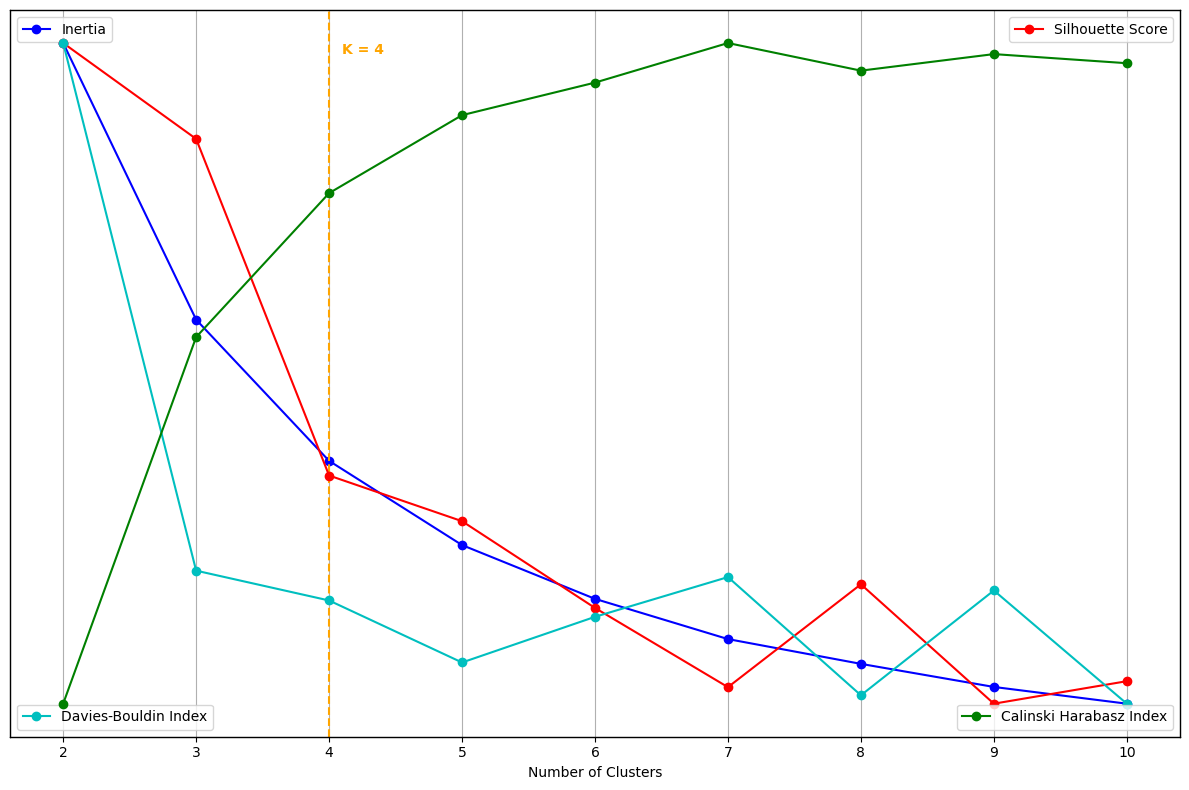


BEST NUMBER OF CLUSTERS (K): 4
Inertia: 24518.44
Silhouette Score: 0.41
Davies-Bouldin Index: 0.80
Calinski Harabasz Index: 5823.68


In [108]:
show_metrics(X_pca,10)

# 8. KMeans

In [109]:
K = 4

kmeans = KMeans(n_clusters=K, n_init=10, init="k-means++")

y_kmeans = kmeans.fit_predict(X_pca)

centroids = kmeans.cluster_centers_

# 9. Clusters Visualization

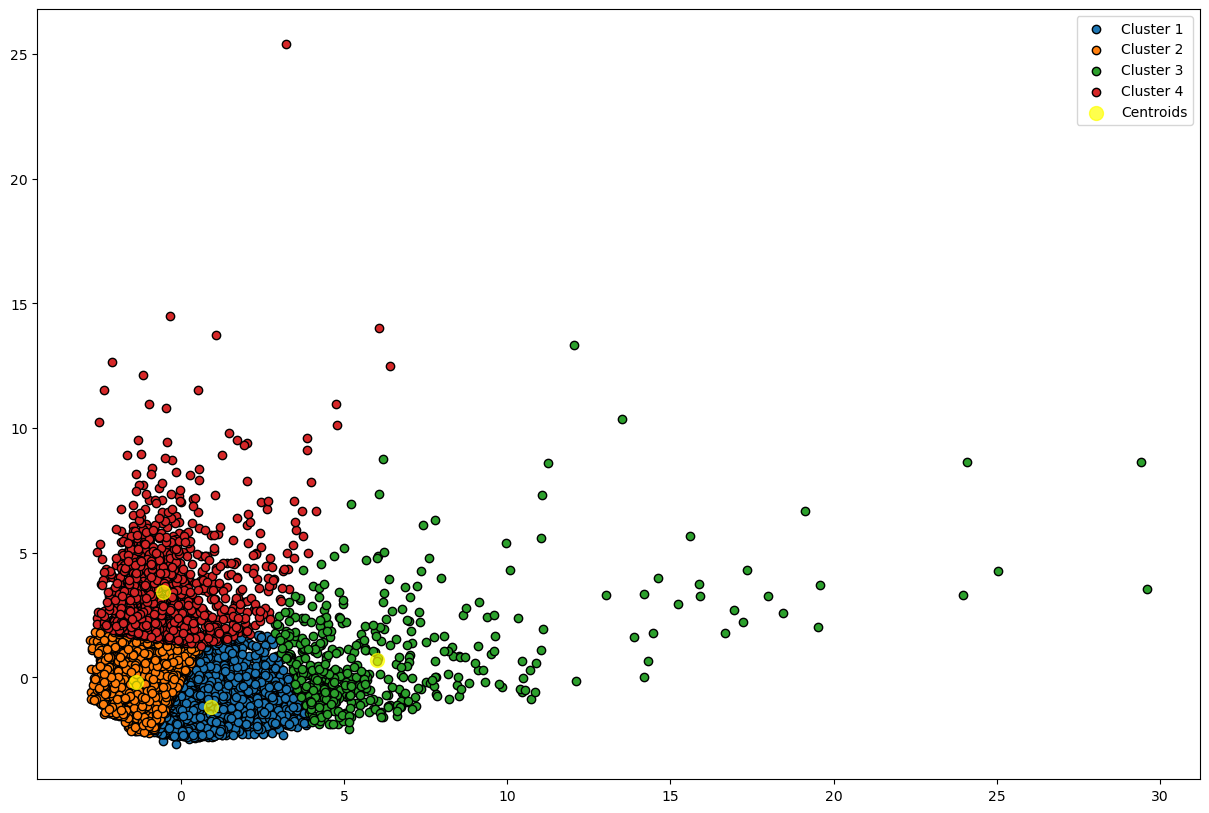

In [110]:
plot_scatter_pca(X_pca,y_kmeans,centroids)

# 10. Final Database - Results

In [28]:
df_final = df_clean.copy()

In [29]:
df_final['CLUSTER'] = y_kmeans+1
df_final.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CLUSTER
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,4
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,2
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,1215.951453,0.000000,12,1
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1


In [30]:
calculate_clusters_profile(df_final)

,Name Column,Metrics,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Total
0,BALANCE,Media,1012.915503,824.180354,3401.840056,4510.612798,1564.474828
1,BALANCE_FREQUENCY,Media,0.799792,0.919997,0.988427,0.963486,0.877271
2,PURCHASES,Media,223.081279,1236.499406,6894.613917,462.647357,1003.204834
3,ONEOFF_PURCHASES,Media,157.576608,621.738764,4511.889901,300.127390,592.437371
4,INSTALLMENTS_PURCHASES,Media,65.833785,614.965725,2383.916859,162.619301,411.067645
5,CASH_ADVANCE,Media,614.588758,147.442197,773.154467,4401.478579,978.871112
6,PURCHASES_FREQUENCY,Media,0.190099,0.862440,0.954443,0.266258,0.490351
7,ONEOFF_PURCHASES_FREQUENCY,Media,0.074901,0.301883,0.726667,0.129829,0.202458
8,PURCHASES_INSTALLMENTS_FREQUENCY,Media,0.109962,0.675116,0.808946,0.166187,0.364437
9,CASH_ADVANCE_FREQUENCY,Media,0.122459,0.030698,0.084806,0.470904,0.135144


Through the use of analysis methodologies, I arrived at the identification of 4 clusters. These clusters present very different characteristics from each other.

CLUSTER 1: Within this class, individuals exhibit moderate balance and balance update frequency. They don't make many purchases, have a very high credit limit and tend to use cash advances more. We can define the cluster of individuals who use the credit card sparingly.

CLUSTER 2: In this cluster, individuals have a lower account balance than the first group. They don't tend to use cash advances, they are more inclined to purchase in installments.

CLUSTER 3: Individuals have a higher balance left on their account than the first two groups. The frequency of updating the balance is very high, they tend to make many purchases both through a single solution and by purchasing in installments.

CLUSTER 4: This group has the largest account balance. The purchases are very numerous, they buy a lot by paying in a single solution but also a lot by paying in installments. They have a very high credit limit.

# 11. Marketing Campaing: What we can do

After identifying the 4 clusters, it is possible to provide solutions to adopt marketing campaigns aimed at increasing the profitability of the financial company.

For CLUSTER 1 - "BLUE" Category - it is necessary to adopt promotions aimed at encouraging the use of credit cards through offers with advantageous interest rates and with the possibility of paying in installments with favorable conditions.

For CLUSTER 2 - "BRONZE" Category - it is necessary to adopt promotions that do not include costs for the adoption of the card and for all methods of payment by credit card. No interest shall be charged for installment payments. This initiative is aimed at encouraging card purchases and changing the behavior of individuals.

For CLUSTER 3 - "SILVER" Category - it is necessary to develop offers aimed at rewarding individuals who spend with a credit card and who pay in installments. Cashback programs can be a valid solution to encourage purchases and increasingly lower interests must be applied as the number of transactions and installments envisaged with this payment method increase.

For CLUSTER 4 - "GOLD" Category - this is the premium group that is not worried about the amounts to spend, seeks experiences and wants to feel special. It is necessary to sign agreements with exclusive brands and to offer unique experiences to make the holders of this card different from others. They must have an exclusive assistant.

In [31]:
df_save = df_final[['CUST_ID', 'CLUSTER']]
df_save.head()

,CUST_ID,CLUSTER
0,C10001,Cluster 1
1,C10002,Cluster 4
2,C10003,Cluster 2
3,C10004,Cluster 1
4,C10005,Cluster 1


In [32]:
df_save.to_excel('project customer segmentation.xlsx', index=False)
print("Project is saved in file Excel 'project customer segmentation.xlsx'")

Project is saved in file Excel 'project customer segmentation.xlsx'
